#  Multi-output Deep Learning for Tropical Cyclone Prediction

## Introduction

Tropical cyclones represent some of the most destructive natural phenomena, causing severe societal and economic impacts.  
Accurate prediction of cyclone **intensity (wind speed, minimum pressure)** and **size** is essential for risk assessment and early warning systems.

In this notebook, we use the **TCIR dataset** (Tropical Cyclone for Image-to-intensity Regression, [BoyoChen, GitHub](https://github.com/BoyoChen/TCIR)) which provides satellite observations from **GridSat** and **CMORPH**.  
The dataset contains over 21,000 cyclone-centered images with 4 channels:  

- Visible (VIS)  
- Infrared (IR)  
- Water Vapour (WV)  
- Passive Microwave (PMW)  

and associated labels such as maximum sustained wind, minimum sea-level pressure, cyclone size, location, and time of measurement.

The primary goal is to build models that can predict **multiple physical variables simultaneously**:  
-  Maximum sustained wind speed (knots)  
-  Minimum central pressure (hPa)  
-  Cyclone size (km)



## Methodological Approach

Since pretrained models such as **ResNet** and **Vision Transformers (ViT)** are designed for RGB inputs (3 channels), we adopt a **hybrid architecture**:  

- The first 3 channels (VIS, IR, WV) are mapped to a "pseudo-RGB" input for the pretrained backbone.  
- The 4th channel (PMW) is processed separately with a lightweight CNN branch.  
- Features are fused before the regression heads for wind, pressure, and size.

This design allows us to:  
1. Leverage **ImageNet pretrained weights** for faster convergence and improved generalization.  
2. Preserve the **physical richness of all satellite channels**.  
3. Provide a framework that can be adapted to **IR-based satellite missions** for storm monitoring and prediction.

---

#Environment Setup

In [ ]:
# 1. Install satellite and scientific libraries
!pip install torch torchvision torchaudio -q
!pip install rasterio xarray netCDF4 h5py -q
!pip install matplotlib seaborn scikit-learn -q

# 2. Import core libraries
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import rasterio
from netCDF4 import Dataset

# 3. Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Environment ready - Using device: {device}")


✅ Environment ready - Using device: cuda


# Data Import (Cyclone Image Dataset via kagglehub)

In [ ]:


# 1. Install kagglehub (new official API)
!pip install kagglehub -q

import kagglehub
import os

# 2. Download the Cyclone Image Dataset
path = kagglehub.dataset_download("vaukaofworlds/thecycloneimagedataset")
print("✅ Path to dataset files:", path)

# 3. List files in dataset
print("📂 Files in dataset:")
print(os.listdir(path)[:20])


✅ Path to dataset files: /kaggle/input/thecycloneimagedataset
📂 Files in dataset:
['Cyclone_Labels h5.npy', 'Cyclone_Images.h5']


# Data Loading + Sampling (5000 obs) :

In [ ]:


import numpy as np
import h5py
import pandas as pd
import torch
import os

# 1. Load Images (take only first 5000)
with h5py.File(os.path.join(path, "Cyclone_Images.h5"), "r") as f:
    images = f["Images"][:5000]   # prendre seulement 5000
print("✅ Images shape:", images.shape, "dtype:", images.dtype)

# 2. Load Labels (NumPy file, allow_pickle=True car dtype=object)
labels = np.load(os.path.join(path, "Cyclone_Labels h5.npy"), allow_pickle=True)[:5000]
print("✅ Labels shape:", labels.shape, "dtype:", labels.dtype)

# 3. Convert labels to DataFrame
labels_df = pd.DataFrame(
    labels,
    columns=["Basin","StormID","Longitude","Latitude","DateTime","Wind","Size","Pressure"]
)
print("\n📑 Labels head:")
print(labels_df.head())

# 4. Convert numeric columns properly
labels_df["Wind"]     = pd.to_numeric(labels_df["Wind"], errors="coerce")
labels_df["Pressure"] = pd.to_numeric(labels_df["Pressure"], errors="coerce")
labels_df["Size"]     = pd.to_numeric(labels_df["Size"], errors="coerce")

# 5. Quick stats (after conversion)
print("\n🌪 Wind stats:", labels_df['Wind'].describe())
print("\n🌡 Pressure stats:", labels_df['Pressure'].describe())
print("\n📏 Size stats:", labels_df['Size'].describe())

# 6. Convert images to Torch tensor
X = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, 4, 128, 128)
print("\n✅ Torch tensor shape:", X.shape)

# 7. Extract labels as tensors (matching correct order)
wind     = torch.tensor(labels_df["Wind"].values, dtype=torch.float32)
pressure = torch.tensor(labels_df["Pressure"].values, dtype=torch.float32)
size     = torch.tensor(labels_df["Size"].values, dtype=torch.float32)

print("\n✅ Labels tensor shapes:", wind.shape, pressure.shape, size.shape)
print("🔎 Example values:", wind[:5].tolist(), pressure[:5].tolist(), size[:5].tolist())


✅ Images shape: (5000, 128, 128, 4) dtype: float32
✅ Labels shape: (5000, 8) dtype: object

📑 Labels head:
  Basin  StormID Longitude Latitude    DateTime  Wind Size Pressure
0  ATLN  200301L     -66.0     31.4  2003041815  30.0  0.0   1008.0
1  ATLN  200301L     -66.3     31.9  2003041818  30.0  0.0   1007.0
2  ATLN  200301L     -66.6     32.5  2003041821  30.0  0.0   1007.0
3  ATLN  200301L     -68.6     34.5  2003041912  35.0  0.0   1006.0
4  ATLN  200301L     -68.8     34.4  2003041915  35.0  0.0   1006.0

🌪 Wind stats: count    5000.000000
mean       47.260000
std        26.064771
min        10.000000
25%        30.000000
50%        40.000000
75%        58.000000
max       150.000000
Name: Wind, dtype: float64

🌡 Pressure stats: count    5000.000000
mean      995.002400
std        18.727534
min       887.000000
25%       990.000000
50%      1002.000000
75%      1007.000000
max      1024.000000
Name: Pressure, dtype: float64

📏 Size stats: count    5000.000000
mean       45.605060


# Bloc 4: Data Verification (final check)

In [ ]:

import torch

# Check for NaN and Inf in images
images_nan = np.isnan(images).any()
images_inf = np.isinf(images).any()

# Check for NaN/Inf in numeric labels
wind_nan      = labels_df["Wind"].isna().any()
pressure_nan  = labels_df["Pressure"].isna().any()
size_nan      = labels_df["Size"].isna().any()

wind_inf      = np.isinf(labels_df["Wind"].astype(float)).any()
pressure_inf  = np.isinf(labels_df["Pressure"].astype(float)).any()
size_inf      = np.isinf(labels_df["Size"].astype(float)).any()

print(" Images - NaN:", images_nan, "| Inf:", images_inf)
print(" Wind - NaN:", wind_nan, "| Inf:", wind_inf)
print(" Pressure - NaN:", pressure_nan, "| Inf:", pressure_inf)
print(" Size - NaN:", size_nan, "| Inf:", size_inf)

# Check basic statistics to detect potential outliers
print("\n--- Statistics check ---")
print("Wind min:", labels_df["Wind"].min(), "max:", labels_df["Wind"].max())
print("Pressure min:", labels_df["Pressure"].min(), "max:", labels_df["Pressure"].max())
print("Size min:", labels_df["Size"].min(), "max:", labels_df["Size"].max())

# Check Torch tensor properties
print("\n Torch tensor shape:", X.shape, "dtype:", X.dtype)
print("   Min pixel value:", torch.min(X).item(), " | Max pixel value:", torch.max(X).item())


 Images - NaN: True | Inf: True
 Wind - NaN: False | Inf: False
 Pressure - NaN: False | Inf: False
 Size - NaN: False | Inf: False

--- Statistics check ---
Wind min: 10.0 max: 150.0
Pressure min: 887.0 max: 1024.0
Size min: 0.0 max: 375.0

 Torch tensor shape: torch.Size([5000, 4, 128, 128]) dtype: torch.float32
   Min pixel value: nan  | Max pixel value: nan


In [ ]:
import numpy as np

# Check NaN / Inf per image
nan_mask = np.isnan(images).any(axis=(1, 2, 3))   # True if at least 1 pixel is NaN
inf_mask = np.isinf(images).any(axis=(1, 2, 3))   # True if at least 1 pixel is Inf

# Count occurrences
num_nan = nan_mask.sum()
num_inf = inf_mask.sum()
num_total = images.shape[0]

print(f" Total images: {num_total}")
print(f" Images containing NaN: {num_nan} ({num_nan/num_total*100:.2f}%)")
print(f" Images containing Inf: {num_inf} ({num_inf/num_total*100:.2f}%)")


 Total images: 5000
 Images containing NaN: 6 (0.12%)
 Images containing Inf: 5 (0.10%)


#Data Cleaning

In [ ]:
# Mask of valid images (no NaN or Inf)
valid_mask = ~nan_mask & ~inf_mask

# Keep only valid images and labels
images_clean = images[valid_mask]
labels_clean = labels[valid_mask]

print(f" Clean dataset size: {images_clean.shape[0]} images")


 Clean dataset size: 4989 images


#Normalization & Dataset Split

In [ ]:

import torch
from sklearn.model_selection import train_test_split
import numpy as np

# 1) Convert to torch tensor (channels first: [N, C, H, W])
X = torch.tensor(images_clean, dtype=torch.float32).permute(0, 3, 1, 2)

# 2) Image normalization to [0, 1] (global)
x_min = torch.amin(X)
x_max = torch.amax(X)
denom = x_max - x_min
X = (X - x_min) / (denom + 1e-8)   # epsilon to avoid /0 if constant


wind     = labels_clean[:, 5].astype(np.float32)
pressure = labels_clean[:, 7].astype(np.float32)
size     = labels_clean[:, 6].astype(np.float32)

# 4) Standardize labels (z-score)
wind_mean, wind_std         = wind.mean(), wind.std()
pressure_mean, pressure_std = pressure.mean(), pressure.std()
size_mean, size_std         = size.mean(), size.std()

# Avoid division by zero if a label is constant
wind_std_safe     = wind_std if wind_std > 0 else 1.0
pressure_std_safe = pressure_std if pressure_std > 0 else 1.0
size_std_safe     = size_std if size_std > 0 else 1.0

wind_norm     = (wind - wind_mean) / wind_std_safe
pressure_norm = (pressure - pressure_mean) / pressure_std_safe
size_norm     = (size - size_mean) / size_std_safe

# Convert to torch tensors
wind     = torch.tensor(wind_norm, dtype=torch.float32)
pressure = torch.tensor(pressure_norm, dtype=torch.float32)
size     = torch.tensor(size_norm, dtype=torch.float32)

# 5) Train / Val / Test split: 70% / 15% / 15%
X_train, X_temp, wind_train, wind_temp, pressure_train, pressure_temp, size_train, size_temp = train_test_split(
    X, wind, pressure, size, test_size=0.3, random_state=42
)
X_val, X_test, wind_val, wind_test, pressure_val, pressure_test, size_val, size_test = train_test_split(
    X_temp, wind_temp, pressure_temp, size_temp, test_size=0.5, random_state=42
)

print(" Dataset split:")
print("Train:", X_train.shape[0])
print("Val:",   X_val.shape[0])
print("Test:",  X_test.shape[0])


label_stats = {
    "wind":     (float(wind_mean),     float(wind_std)),
    "pressure": (float(pressure_mean), float(pressure_std)),
    "size":     (float(size_mean),     float(size_std)),
}
print(" Label stats saved:", label_stats)


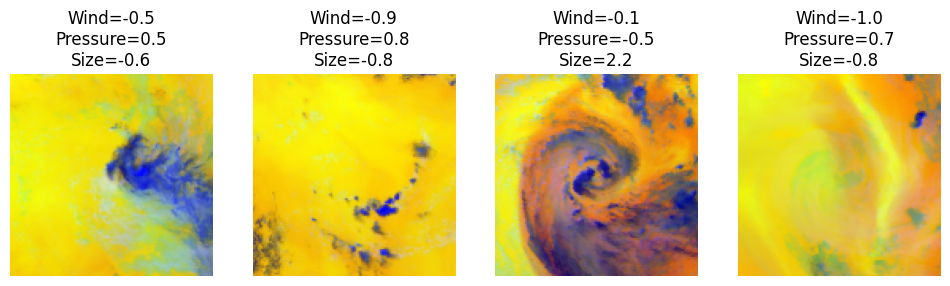

In [ ]:
import random
import matplotlib.pyplot as plt

def show_random_examples(X, wind, pressure, size, n=4):
    """
    Show n random examples from the dataset with their corresponding labels.

    Args:
        X (torch.Tensor): Image tensor of shape [N, C, H, W].
                         Channels = [IR, WV, VIS, PMW].
        wind (torch.Tensor): Wind labels.
        pressure (torch.Tensor): Pressure labels.
        size (torch.Tensor): Size labels.
        n (int): Number of random samples to display.
    """
    plt.figure(figsize=(12, 6))
    indices = random.sample(range(len(X)), n)  # select n random indices

    for j, i in enumerate(indices):
        # Convert tensor to numpy, permute to HWC for display
        img = X[i].permute(1, 2, 0).cpu().numpy()

        plt.subplot(1, n, j+1)
        # Show pseudo-RGB using first 3 channels: (IR, WV, VIS)
        plt.imshow(img[:, :, :3])
        plt.title(
            f"Wind={wind[i].item():.1f}\n"
            f"Pressure={pressure[i].item():.1f}\n"
            f"Size={size[i].item():.1f}"
        )
        plt.axis("off")

    plt.show()

# Example: show 4 random training images
show_random_examples(X_train, wind_train, pressure_train, size_train, n=4)


#PyTorch Dataset & DataLoader

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch, os

# 1) Custom Dataset class
class CycloneDataset(Dataset):
    def __init__(self, X, wind, pressure, size):
        n = len(X)
        assert len(wind) == n and len(pressure) == n and len(size) == n, "Label lengths must match X"

        self.X = X.to(dtype=torch.float32).contiguous()
        self.wind = wind.to(dtype=torch.float32).contiguous()
        self.pressure = pressure.to(dtype=torch.float32).contiguous()
        self.size = size.to(dtype=torch.float32).contiguous()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return (
            self.X[idx],
            self.wind[idx],
            self.pressure[idx],
            self.size[idx],
        )

# 2) Build Datasets
train_dataset = CycloneDataset(X_train, wind_train, pressure_train, size_train)
val_dataset   = CycloneDataset(X_val,   wind_val,   pressure_val, size_val)
test_dataset  = CycloneDataset(X_test,  wind_test,  pressure_test, size_test)

# 3) Build DataLoaders
num_workers = max(1, (os.cpu_count() or 2) // 2)
pin_memory = torch.cuda.is_available()

train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True,
    num_workers=num_workers, pin_memory=pin_memory,
    persistent_workers=num_workers > 0
)
val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False,
    num_workers=num_workers, pin_memory=pin_memory,
    persistent_workers=num_workers > 0
)
test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False,
    num_workers=num_workers, pin_memory=pin_memory,
    persistent_workers=num_workers > 0
)

print("DataLoaders ready:")
print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Test batches: {len(test_loader)}")


DataLoaders ready:
Train batches: 110 | Val batches: 24 | Test batches: 24


##Test DataLoader

🖼 Images batch: torch.Size([32, 4, 128, 128]) torch.float32
🌪 Wind batch: torch.Size([32]) torch.float32 min: -1.1239542961120605 max: 3.862658739089966
🌡 Pressure batch: torch.Size([32]) torch.float32 min: -4.643097877502441 max: 0.9621509313583374
📏 Size batch: torch.Size([32]) torch.float32 min: -0.7514981031417847 max: 3.572206974029541


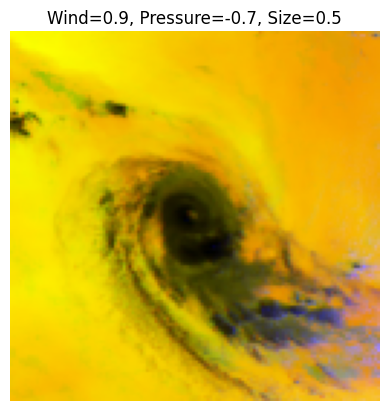

In [ ]:
# Retrieve one batch from the train_loader
sample_batch = next(iter(train_loader))
images, wind, pressure, size = sample_batch   # ✅ order matches Dataset definition

print("🖼 Images batch:", images.shape, images.dtype)
print("🌪 Wind batch:", wind.shape, wind.dtype, "min:", wind.min().item(), "max:", wind.max().item())
print("🌡 Pressure batch:", pressure.shape, pressure.dtype, "min:", pressure.min().item(), "max:", pressure.max().item())
print("📏 Size batch:", size.shape, size.dtype, "min:", size.min().item(), "max:", size.max().item())

# Quick visual check
import matplotlib.pyplot as plt

# First sample in batch
img = images[0].permute(1, 2, 0).cpu().numpy()   # shape [H, W, C]

plt.figure(figsize=(6,6))
# Display only first 3 channels (pseudo-RGB = VIS, IR, WV)
plt.imshow(img[:, :, :3])
plt.title(
    f"Wind={wind[0].item():.1f}, "
    f"Pressure={pressure[0].item():.1f}, "
    f"Size={size[0].item():.1f}"
)
plt.axis("off")
plt.show()


## Exploratory Data Analysis of Labels (Pressure & Size)

In this section, we perform a quick exploratory analysis of the target variables:
- **Descriptive statistics** (mean and standard deviation)  
- **Histograms** to visualize the distribution of values  
- **Boxplots** to detect potential outliers  

This helps us better understand the scale and variability of the pressure and cyclone size values before training.


Pressure -> mean: -7.510686277936995e-07 std: 1.0000000361715577
Size     -> mean: -3.534398572009798e-08 std: 1.0000000097931943


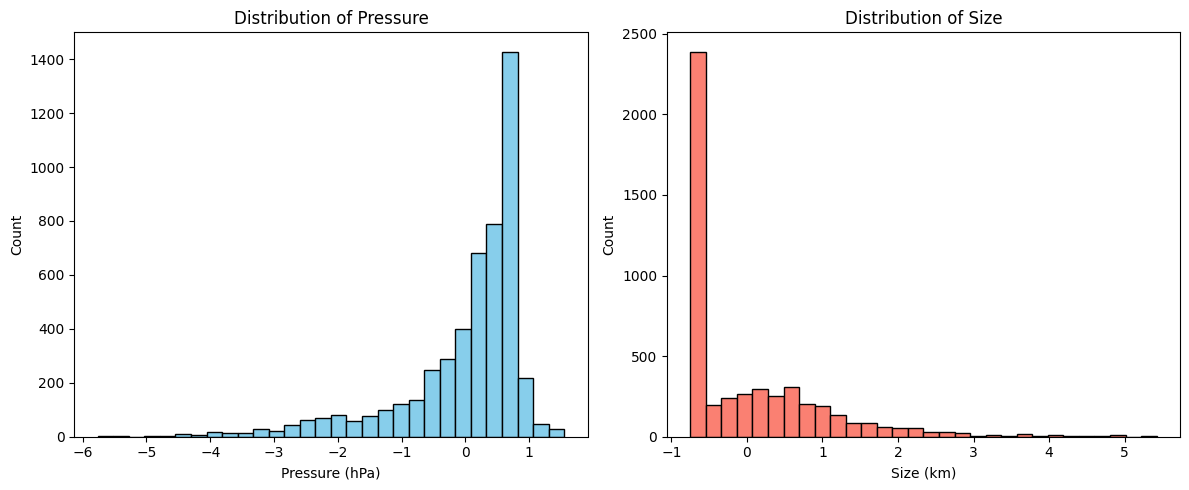

/tmp/ipython-input-3766962343.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([pressure_all, size_all], labels=["Pressure (hPa)", "Size (km)"])


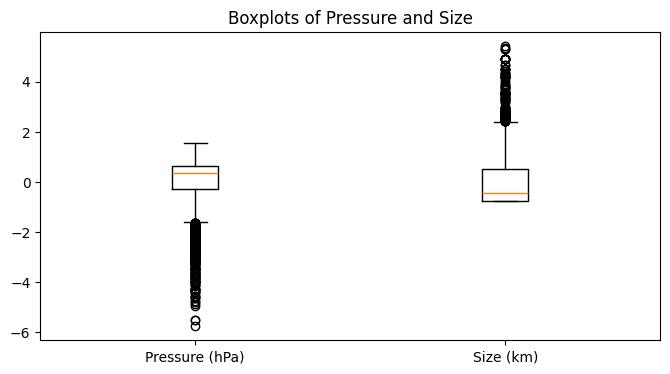

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you still have the raw (non-normalized) label tensors/arrays
pressure_all = (
    pressure_train.cpu().numpy().tolist()
    + pressure_val.cpu().numpy().tolist()
    + pressure_test.cpu().numpy().tolist()
)
size_all = (
    size_train.cpu().numpy().tolist()
    + size_val.cpu().numpy().tolist()
    + size_test.cpu().numpy().tolist()
)

# 1) Descriptive statistics
print("Pressure -> mean:", np.mean(pressure_all), "std:", np.std(pressure_all))
print("Size     -> mean:", np.mean(size_all), "std:", np.std(size_all))

# 2) Histograms
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(pressure_all, bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Pressure")
plt.xlabel("Pressure (hPa)")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(size_all, bins=30, color="salmon", edgecolor="black")
plt.title("Distribution of Cyclone Size")
plt.xlabel("Size (km)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

# 3) Boxplots to inspect potential outliers
plt.figure(figsize=(8,4))
plt.boxplot([pressure_all, size_all], labels=["Pressure (hPa)", "Size (km)"])
plt.title("Boxplots of Pressure and Size")
plt.show()



# Definition of multi-output CNN model

In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiOutputCNN(nn.Module):
    def __init__(self):
        super(MultiOutputCNN, self).__init__()

        # --- Convolutional feature extractor ---
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)   # Input: 4 channels (RGB + extra)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # After 3x pooling (2x2), assuming input images = [B, 4, 128, 128]:
        # conv1 → [B, 32, 128, 128] → pool → [B, 32, 64, 64]
        # conv2 → [B, 64, 64, 64]  → pool → [B, 64, 32, 32]
        # conv3 → [B, 128, 32, 32] → pool → [B, 128, 16, 16]

        # --- Fully connected layers ---
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 128)

        # --- Separate heads for multi-target regression ---
        self.fc_wind     = nn.Linear(128, 1)   # Wind
        self.fc_pressure = nn.Linear(128, 1)   # Pressure
        self.fc_size     = nn.Linear(128, 1)   # Size

    def forward(self, x):
        # CNN feature extractor
        x = self.pool(F.relu(self.conv1(x)))   # [B, 32, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))   # [B, 64, 32, 32]
        x = self.pool(F.relu(self.conv3(x)))   # [B, 128, 16, 16]

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Outputs (avoid squeeze() collapsing batch dim when B=1)
        wind     = self.fc_wind(x).view(-1)
        pressure = self.fc_pressure(x).view(-1)
        size     = self.fc_size(x).view(-1)

        return wind, pressure, size


##Quick model test

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("🖥 Using device:", device)

# Initialize model
model = MultiOutputCNN().to(device)

# Get a mini-batch from the training loader
batch = next(iter(train_loader))
images, wind, size, pressure = batch
images    = images.to(device)
wind      = wind.to(device)
size      = size.to(device)
pressure  = pressure.to(device)

# Forward pass (no gradient computation)
with torch.no_grad():
    out_wind, out_pressure, out_size = model(images)

# Check tensor shapes
print("Batch input:", images.shape)
print("Wind prediction:", out_wind.shape)
print("Pressure prediction:", out_pressure.shape)
print("Size prediction:", out_size.shape)


🖥 Using device: cuda
Batch input: torch.Size([32, 4, 128, 128])
Wind prediction: torch.Size([32])
Pressure prediction: torch.Size([32])
Size prediction: torch.Size([32])


##Loss functions & Optimizer

In [ ]:

import torch.nn as nn

# Separate loss functions for each output (MSE since this is regression)
criterion_wind     = nn.MSELoss()
criterion_pressure = nn.MSELoss()
criterion_size     = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print("Loss functions and optimizer ready")


Loss functions and optimizer ready


##Quik test of Loss functions & Optimizer

In [ ]:

# Get one batch from train loader
images, wind, size, pressure = next(iter(train_loader))
images, wind, size, pressure = (
    images.to(device),
    wind.to(device),
    size.to(device),
    pressure.to(device),
)

# Forward pass
out_wind, out_pressure, out_size = model(images)

# Compute individual losses
loss_wind     = criterion_wind(out_wind, wind)
loss_pressure = criterion_pressure(out_pressure, pressure)
loss_size     = criterion_size(out_size, size)

# Total loss (simple sum, can also be weighted if needed)
loss_total = loss_wind + loss_pressure + loss_size

print(" Wind loss:", loss_wind.item())
print(" Pressure loss:", loss_pressure.item())
print(" Size loss:", loss_size.item())
print(" Total loss:", loss_total.item())

# Test backward pass
optimizer.zero_grad()
loss_total.backward()
optimizer.step()

print("Backward & optimizer step OK")


 Wind loss: 0.5079703330993652
 Pressure loss: 1.6907374858856201
 Size loss: 0.40809372067451477
 Total loss: 2.6068015098571777
Backward & optimizer step OK


##Training Loop with best model saving

In [ ]:
import torch
import torch.nn as nn
import copy

# Shared loss function
criterion = nn.MSELoss()

def train_model(model, train_loader, val_loader, optimizer, num_epochs=50, device="cuda"):
    history = {"train_loss": [], "val_loss": []}
    best_val_loss = float("inf")
    best_model = None

    for epoch in range(num_epochs):
        # --- Training ---
        model.train()
        train_loss = 0.0

        for images, wind, pressure, size in train_loader:
            images, wind, pressure, size = (
                images.to(device),
                wind.to(device),
                pressure.to(device),
                size.to(device),
            )

            optimizer.zero_grad()
            out_wind, out_pressure, out_size = model(images)

            loss_wind     = criterion(out_wind, wind)
            loss_pressure = criterion(out_pressure, pressure)
            loss_size     = criterion(out_size, size)

            loss = loss_wind + loss_pressure + loss_size
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # --- Validation ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, wind, pressure, size in val_loader:
                images, wind, pressure, size = (
                    images.to(device),
                    wind.to(device),
                    pressure.to(device),
                    size.to(device),
                )
                out_wind, out_pressure, out_size = model(images)

                loss_wind     = criterion(out_wind, wind)
                loss_pressure = criterion(out_pressure, pressure)
                loss_size     = criterion(out_size, size)

                loss = loss_wind + loss_pressure + loss_size
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # --- Save history ---
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        # --- Check best model ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)  # deep copy

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f}")

    print(f"\n Training done! Best Val Loss = {best_val_loss:.4f}")
    return best_model, history


In [ ]:
best_model, history = train_model(model, train_loader, val_loader, optimizer, num_epochs=50, device=device)


Epoch 1/50 | Train Loss=1.8893 | Val Loss=1.7055
Epoch 2/50 | Train Loss=1.4508 | Val Loss=1.3881
Epoch 3/50 | Train Loss=1.2914 | Val Loss=1.3329
Epoch 4/50 | Train Loss=1.1034 | Val Loss=1.3576
Epoch 5/50 | Train Loss=1.0006 | Val Loss=1.1345
Epoch 6/50 | Train Loss=0.8205 | Val Loss=1.1249
Epoch 7/50 | Train Loss=0.6689 | Val Loss=1.1285
Epoch 8/50 | Train Loss=0.5543 | Val Loss=1.0099
Epoch 9/50 | Train Loss=0.4505 | Val Loss=1.0795
Epoch 10/50 | Train Loss=0.3381 | Val Loss=0.9023
Epoch 11/50 | Train Loss=0.2786 | Val Loss=0.9012
Epoch 12/50 | Train Loss=0.2268 | Val Loss=0.9173
Epoch 13/50 | Train Loss=0.1738 | Val Loss=0.9109
Epoch 14/50 | Train Loss=0.1377 | Val Loss=0.8691
Epoch 15/50 | Train Loss=0.1031 | Val Loss=0.8511
Epoch 16/50 | Train Loss=0.0905 | Val Loss=0.8826
Epoch 17/50 | Train Loss=0.0751 | Val Loss=0.8509
Epoch 18/50 | Train Loss=0.0687 | Val Loss=0.8165
Epoch 19/50 | Train Loss=0.0660 | Val Loss=0.8550
Epoch 20/50 | Train Loss=0.0530 | Val Loss=0.8349
Epoch 21/

## Learning Curves

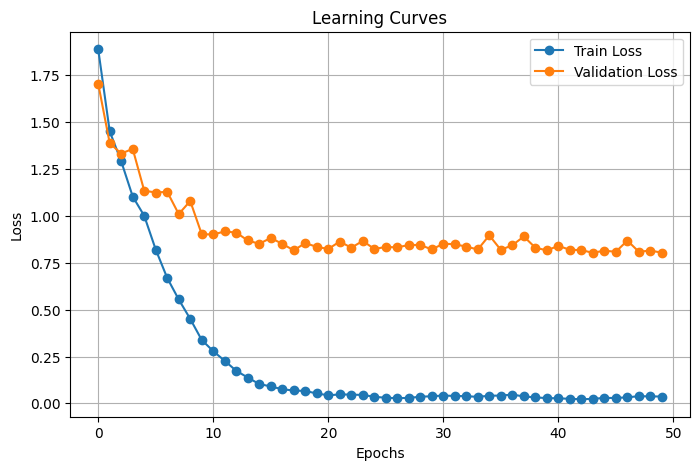

In [ ]:

import matplotlib.pyplot as plt

def plot_training_curves(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history["train_loss"], label="Train Loss", marker="o")
    plt.plot(history["val_loss"], label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Learning Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

#  Visualization
plot_training_curves(history)


##Test Evaluation

## Test Evaluation (with denormalization, MSE, RMSE, R²)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

criterion = nn.MSELoss()

def evaluate_model(model, test_loader, device, label_stats):
    model.eval()

    wind_mean, wind_std = label_stats["wind"]
    size_mean, size_std = label_stats["size"]
    pressure_mean, pressure_std = label_stats["pressure"]

    # Store predictions and ground truth for metrics
    y_true_wind, y_pred_wind = [], []
    y_true_pressure, y_pred_pressure = [], []
    y_true_size, y_pred_size = [], []

    with torch.no_grad():
        for images, wind, pressure, size in test_loader:
            images, wind, pressure, size = (
                images.to(device),
                wind.to(device),
                pressure.to(device),
                size.to(device),
            )

            # 🔮 Forward
            out_wind, out_pressure, out_size = model(images)

            # 📏 Denormalization (back to real units)
            wind_pred     = out_wind.cpu().numpy() * wind_std + wind_mean
            pressure_pred = out_pressure.cpu().numpy() * pressure_std + pressure_mean
            size_pred     = out_size.cpu().numpy() * size_std + size_mean

            wind_true     = wind.cpu().numpy() * wind_std + wind_mean
            pressure_true = pressure.cpu().numpy() * pressure_std + pressure_mean
            size_true     = size.cpu().numpy() * size_std + size_mean

            # Store
            y_true_wind.extend(wind_true)
            y_pred_wind.extend(wind_pred)
            y_true_pressure.extend(pressure_true)
            y_pred_pressure.extend(pressure_pred)
            y_true_size.extend(size_true)
            y_pred_size.extend(size_pred)

    # === Metrics ===
    mse_wind     = mean_squared_error(y_true_wind, y_pred_wind)
    mse_pressure = mean_squared_error(y_true_pressure, y_pred_pressure)
    mse_size     = mean_squared_error(y_true_size, y_pred_size)

    rmse_wind     = np.sqrt(mse_wind)
    rmse_pressure = np.sqrt(mse_pressure)
    rmse_size     = np.sqrt(mse_size)

    r2_wind     = r2_score(y_true_wind, y_pred_wind)
    r2_pressure = r2_score(y_true_pressure, y_pred_pressure)
    r2_size     = r2_score(y_true_size, y_pred_size)

    print("\nTest Results (real units):")
    print(f"Wind     -> MSE: {mse_wind:.2f} | RMSE: {rmse_wind:.2f} knots | R²: {r2_wind:.3f}")
    print(f"Pressure -> MSE: {mse_pressure:.2f} | RMSE: {rmse_pressure:.2f} hPa   | R²: {r2_pressure:.3f}")
    print(f"Size     -> MSE: {mse_size:.2f} | RMSE: {rmse_size:.2f} km     | R²: {r2_size:.3f}")
    print(f"Total MSE (sum): {mse_wind + mse_pressure + mse_size:.2f}")

    return {
        "MSE": {"wind": mse_wind, "pressure": mse_pressure, "size": mse_size},
        "RMSE": {"wind": rmse_wind, "pressure": rmse_pressure, "size": rmse_size},
        "R2": {"wind": r2_wind, "pressure": r2_pressure, "size": r2_size},
    }

# Run on test set
metrics = evaluate_model(best_model, test_loader, device, label_stats)



Test Results (real units):
Wind     -> MSE: 159.35 | RMSE: 12.62 knots | R²: 0.789
Pressure -> MSE: 76.81 | RMSE: 8.76 hPa   | R²: 0.803
Size     -> MSE: 1599.09 | RMSE: 39.99 km     | R²: 0.577
Total MSE (sum): 1835.25


# ResNet model

##ResNet + CNN for 4th channel

In [ ]:

import torch
import torch.nn as nn
import torchvision.models as models

class ResNetWithCNNExtra(nn.Module):
    def __init__(self, base_model="resnet18", pretrained=True):
        super().__init__()

        # --- ResNet backbone (handles the 3 RGB channels) ---
        if base_model == "resnet18":
            backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None)
            feat_dim = 512
        elif base_model == "resnet50":
            backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1 if pretrained else None)
            feat_dim = 2048
        else:
            raise ValueError("Unsupported ResNet model")

        # Remove the final fully connected layer -> keep feature extractor
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])  # -> [B, feat_dim, 1, 1]

        # --- Small CNN for the extra (4th) channel ---
        self.extra_cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # [B,16,112,112]
            nn.ReLU(),
            nn.MaxPool2d(2),                                       # [B,16,56,56]
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # [B,32,28,28]
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),                           # [B,32,1,1]
            nn.Flatten(),                                          # [B,32]
            nn.Linear(32, 128),                                    # [B,128]
            nn.ReLU()
        )

        # --- Fusion layer (combine ResNet features + extra channel features) ---
        self.fc_fusion = nn.Sequential(
            nn.Linear(feat_dim + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # --- Regression heads ---
        self.fc_wind = nn.Linear(256, 1)
        self.fc_pressure = nn.Linear(256, 1)
        self.fc_size = nn.Linear(256, 1)

    def forward(self, x):
        # Separate RGB and extra channel
        rgb   = x[:, :3, :, :]   # [B,3,224,224]
        extra = x[:, 3:, :, :]   # [B,1,224,224]

        # ResNet features
        feat_rgb = self.backbone(rgb).view(rgb.size(0), -1)   # [B, feat_dim]

        # Extra CNN features
        feat_extra = self.extra_cnn(extra)                    # [B,128]

        # Fusion
        feat = torch.cat([feat_rgb, feat_extra], dim=1)       # [B, feat_dim+128]
        feat = self.fc_fusion(feat)                           # [B,256]

        # Outputs (use view(-1) to avoid losing batch dimension if B=1)
        return (
            self.fc_wind(feat).view(-1),
            self.fc_pressure(feat).view(-1),
            self.fc_size(feat).view(-1)
        )


# ✅ Quick test
device = "cuda" if torch.cuda.is_available() else "cpu"
model_hybrid_cnn = ResNetWithCNNExtra("resnet18", pretrained=True).to(device)

dummy_input = torch.randn(4, 4, 224, 224).to(device)
out_wind, out_pressure, out_size = model_hybrid_cnn(dummy_input)

print("Wind:", out_wind.shape, "| Pressure:", out_pressure.shape, "| Size:", out_size.shape)
# Expected -> Wind: torch.Size([4]) | Pressure: torch.Size([4]) | Size: torch.Size([4])


Wind: torch.Size([4]) | Pressure: torch.Size([4]) | Size: torch.Size([4])


##Training Loop for ResNetWithCNNExtra

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# --- Loss ---
criterion = nn.MSELoss()

def train_model(model, train_loader, val_loader, optimizer, num_epochs=30, device="cuda"):
    history = {"train_loss": [], "val_loss": []}
    best_val_loss = float("inf")
    best_model_state = None

    for epoch in range(num_epochs):
        # --- TRAIN ---
        model.train()
        train_loss = 0.0
        for images, wind, pressure, size in train_loader:
            images, wind, pressure, size = (
                images.to(device),
                wind.to(device),
                pressure.to(device),
                size.to(device),
            )

            optimizer.zero_grad()
            out_wind, out_pressure, out_size = model(images)

            loss_wind     = criterion(out_wind, wind)
            loss_pressure = criterion(out_pressure, pressure)
            loss_size     = criterion(out_size, size)

            loss = loss_wind + loss_pressure + loss_size
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # --- VALIDATION ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, wind, pressure, size in val_loader:
                images, wind, pressure, size = (
                    images.to(device),
                    wind.to(device),
                    pressure.to(device),
                    size.to(device),
                )
                out_wind, out_pressure, out_size = model(images)

                loss_wind     = criterion(out_wind, wind)
                loss_pressure = criterion(out_pressure, pressure)
                loss_size     = criterion(out_size, size)

                loss = loss_wind + loss_pressure + loss_size
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # --- Save best model ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f}")

    # Reload best model weights
    model.load_state_dict(best_model_state)
    return history, model


# ⚡ Initialize model + optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model_resnet_cnn = ResNetWithCNNExtra("resnet18", pretrained=True).to(device)
optimizer = optim.Adam(model_resnet_cnn.parameters(), lr=1e-4)

# ⚡ Run training
history_resnet_cnn, best_resnet_cnn = train_model(
    model_resnet_cnn, train_loader, val_loader, optimizer,
    num_epochs=50, device=device
)


Epoch 1/50 | Train Loss=1.3989 | Val Loss=1.0704
Epoch 2/50 | Train Loss=0.7249 | Val Loss=0.7907
Epoch 3/50 | Train Loss=0.4523 | Val Loss=0.7126
Epoch 4/50 | Train Loss=0.3176 | Val Loss=0.6719
Epoch 5/50 | Train Loss=0.3074 | Val Loss=0.6610
Epoch 6/50 | Train Loss=0.3029 | Val Loss=0.6497
Epoch 7/50 | Train Loss=0.2497 | Val Loss=0.5860
Epoch 8/50 | Train Loss=0.2201 | Val Loss=0.5941
Epoch 9/50 | Train Loss=0.2230 | Val Loss=0.5789
Epoch 10/50 | Train Loss=0.2025 | Val Loss=0.5964
Epoch 11/50 | Train Loss=0.1828 | Val Loss=0.5442
Epoch 12/50 | Train Loss=0.1542 | Val Loss=0.5784
Epoch 13/50 | Train Loss=0.1667 | Val Loss=0.5609
Epoch 14/50 | Train Loss=0.1570 | Val Loss=0.5593
Epoch 15/50 | Train Loss=0.1554 | Val Loss=0.5846
Epoch 16/50 | Train Loss=0.1400 | Val Loss=0.5680
Epoch 17/50 | Train Loss=0.1272 | Val Loss=0.5386
Epoch 18/50 | Train Loss=0.1237 | Val Loss=0.5400
Epoch 19/50 | Train Loss=0.1297 | Val Loss=0.5440
Epoch 20/50 | Train Loss=0.1310 | Val Loss=0.5318
Epoch 21/

## Learning Curves

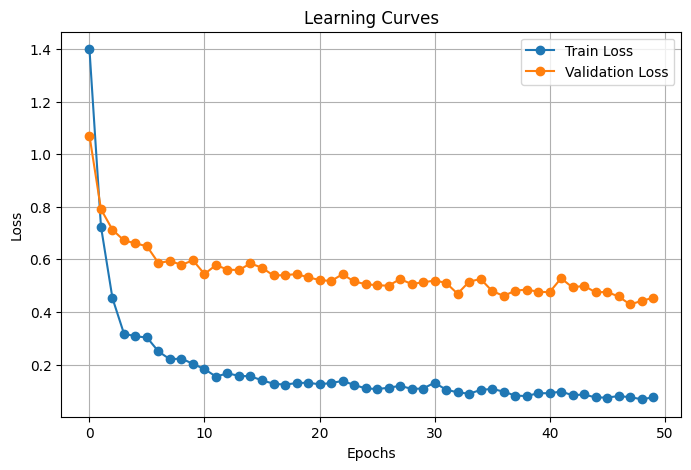

In [ ]:
#  Visualization
plot_training_curves(history_resnet_cnn)

## Test Evaluation

In [ ]:
# Run on test set
metrics = evaluate_model(best_resnet_cnn, test_loader, device, label_stats)



Test Results (real units):
Wind     -> MSE: 77.12 | RMSE: 8.78 knots | R²: 0.898
Pressure -> MSE: 33.12 | RMSE: 5.76 hPa   | R²: 0.915
Size     -> MSE: 1041.51 | RMSE: 32.27 km     | R²: 0.725
Total MSE (sum): 1151.75


#Vision Transformer (ViT) Model

## (ViT) + CNN for 4th channel

In [ ]:

import torch
import torch.nn as nn
from torchvision.models import vit_b_16, ViT_B_16_Weights
import torch.nn.functional as F

class ViTWithCNNExtra(nn.Module):
    def __init__(self, pretrained=True, fine_tune_last_block=True):
        super().__init__()

        # --- Load pretrained ViT backbone (handles RGB) ---
        self.vit = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1 if pretrained else None)
        self.vit.heads = nn.Identity()
        feat_dim = 768  # Feature size for ViT-B/16

        # --- Freeze backbone ---
        for param in self.vit.parameters():
            param.requires_grad = False

        # ✅ Unfreeze last 3 transformer encoder blocks
        if fine_tune_last_block:
            for block in self.vit.encoder.layers[-3:]:
                for param in block.parameters():
                    param.requires_grad = True

        # --- Small CNN for the 4th channel ---
        self.extra_cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(32, 128),
            nn.ReLU()
        )

        # --- Fusion ---
        self.fc_fusion = nn.Sequential(
            nn.Linear(feat_dim + 128, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # --- Regression heads ---
        self.fc_wind     = nn.Linear(256, 1)
        self.fc_pressure = nn.Linear(256, 1)
        self.fc_size     = nn.Linear(256, 1)

    def forward(self, x):
        x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)
        rgb   = x[:, :3, :, :]
        extra = x[:, 3:, :, :]

        feat_rgb   = self.vit(rgb)
        feat_extra = self.extra_cnn(extra)

        feat = torch.cat([feat_rgb, feat_extra], dim=1)
        feat = self.fc_fusion(feat)

        return (
            self.fc_wind(feat).view(-1),
            self.fc_pressure(feat).view(-1),
            self.fc_size(feat).view(-1)
        )



# ✅ Quick test
device = "cuda" if torch.cuda.is_available() else "cpu"
model_vit_cnn = ViTWithCNNExtra(pretrained=True).to(device)

dummy_input = torch.randn(4, 4, 224, 224).to(device)
out_wind, out_pressure, out_size = model_vit_cnn(dummy_input)

print("Wind:", out_wind.shape, "| Pressure:", out_pressure.shape, "| Size:", out_size.shape)
# Expected -> torch.Size([4]) for each output


Wind: torch.Size([4]) | Pressure: torch.Size([4]) | Size: torch.Size([4])


##Training Loop for ViT+CNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# 🔹 Loss
criterion = nn.MSELoss()

def train_model(model, train_loader, val_loader, optimizer, num_epochs=30, device="cuda"):
    history = {"train_loss": [], "val_loss": []}
    best_val_loss = float("inf")
    best_model_state = None

    for epoch in range(num_epochs):
        # --- TRAIN ---
        model.train()
        train_loss = 0.0
        for images, wind, pressure, size in train_loader:
            images, wind, pressure, size = (
                images.to(device),
                wind.to(device),
                pressure.to(device),
                size.to(device),
            )

            optimizer.zero_grad()
            out_wind, out_pressure, out_size = model(images)

            # Multi-loss
            loss_wind     = criterion(out_wind, wind)
            loss_pressure = criterion(out_pressure, pressure)
            loss_size     = criterion(out_size, size)

            loss = loss_wind + loss_pressure + loss_size
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # --- VALIDATION ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, wind, pressure, size in val_loader:
                images, wind, pressure, size = (
                    images.to(device),
                    wind.to(device),
                    pressure.to(device),
                    size.to(device),
                )
                out_wind, out_pressure, out_size = model(images)

                loss_wind     = criterion(out_wind, wind)
                loss_pressure = criterion(out_pressure, pressure)
                loss_size     = criterion(out_size, size)

                loss = loss_wind + loss_pressure + loss_size
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # --- Save best model ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_state)
    return history, model


# ⚡ Initialize model + optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model_vit_cnn = ViTWithCNNExtra(pretrained=True).to(device)
optimizer = optim.Adam(model_vit_cnn.parameters(), lr=1e-4)

# ⚡ Run training
history_vit, best_vit = train_model(
    model_vit_cnn, train_loader, val_loader, optimizer,
    num_epochs=50, device=device
)


Epoch 1/50 | Train Loss=1.4834 | Val Loss=1.2754
Epoch 2/50 | Train Loss=1.0407 | Val Loss=1.0322
Epoch 3/50 | Train Loss=0.7835 | Val Loss=1.0893
Epoch 4/50 | Train Loss=0.6150 | Val Loss=0.9321
Epoch 5/50 | Train Loss=0.4724 | Val Loss=0.9690
Epoch 6/50 | Train Loss=0.3370 | Val Loss=0.8460
Epoch 7/50 | Train Loss=0.2875 | Val Loss=0.8123
Epoch 8/50 | Train Loss=0.2339 | Val Loss=0.8329
Epoch 9/50 | Train Loss=0.1737 | Val Loss=0.7830
Epoch 10/50 | Train Loss=0.1486 | Val Loss=0.8017
Epoch 11/50 | Train Loss=0.1319 | Val Loss=0.7736
Epoch 12/50 | Train Loss=0.1177 | Val Loss=0.7509
Epoch 13/50 | Train Loss=0.0991 | Val Loss=0.7457
Epoch 14/50 | Train Loss=0.0957 | Val Loss=0.7403
Epoch 15/50 | Train Loss=0.0926 | Val Loss=0.7747
Epoch 16/50 | Train Loss=0.0850 | Val Loss=0.7600
Epoch 17/50 | Train Loss=0.0867 | Val Loss=0.7320
Epoch 18/50 | Train Loss=0.0801 | Val Loss=0.7510
Epoch 19/50 | Train Loss=0.0790 | Val Loss=0.7686
Epoch 20/50 | Train Loss=0.0787 | Val Loss=0.8366
Epoch 21/

## Learning Curves

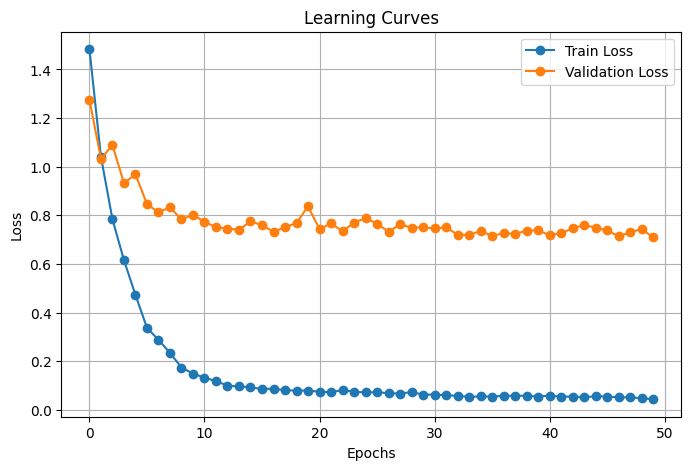

In [ ]:
#  Visualization
plot_training_curves(history_vit)

## Test Evaluation

In [ ]:
# Run on test set
metrics = evaluate_model(best_vit, test_loader, device, label_stats)


Test Results (real units):
Wind     -> MSE: 130.89 | RMSE: 11.44 knots | R²: 0.826
Pressure -> MSE: 61.08 | RMSE: 7.82 hPa   | R²: 0.844
Size     -> MSE: 1250.82 | RMSE: 35.37 km     | R²: 0.669
Total MSE (sum): 1442.79


## 📈 Model Evaluation and Comparison

In this section, we evaluate the three models (**MultiOutputCNN, ResNet+CNN, ViT+CNN**) on the test set.  
For each model, we compute the following metrics for **Wind, Pressure, and Size**:

- **MSE** (Mean Squared Error)  
- **RMSE** (Root Mean Squared Error, in real units)  
- **R²** (Coefficient of determination)

We also visualize:
- **Scatter plots** (true vs. predicted values with the ideal diagonal line)  
- **Bar plots** comparing RMSE across models  

This helps us understand both the accuracy and generalization ability of each model.



=== MultiOutputCNN ===
Wind     -> MSE: 0.23 | RMSE: 0.48 | R²: 0.789


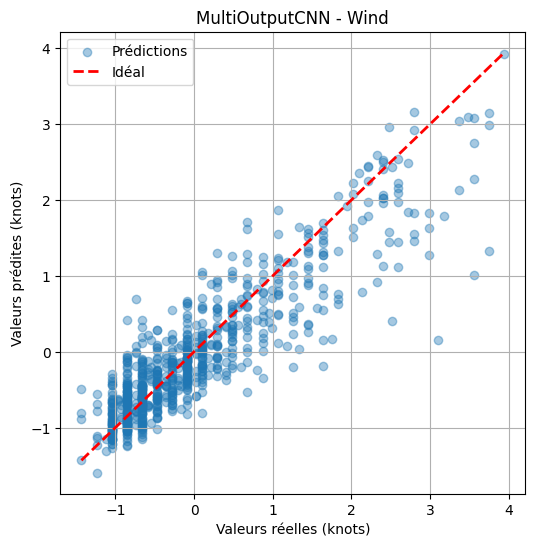

Pressure -> MSE: 0.22 | RMSE: 0.47 | R²: 0.803


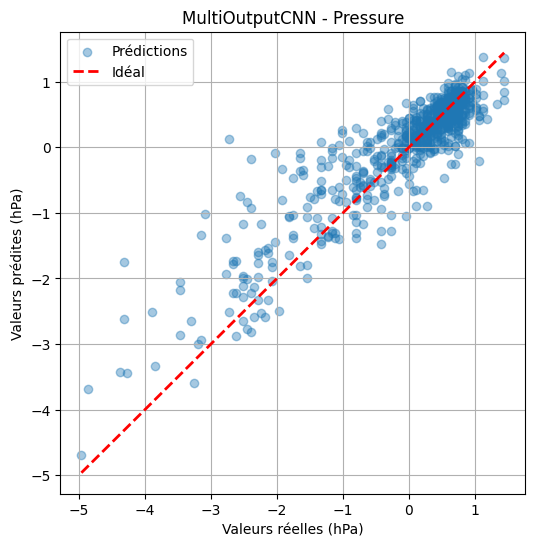

Size     -> MSE: 0.43 | RMSE: 0.66 | R²: 0.577


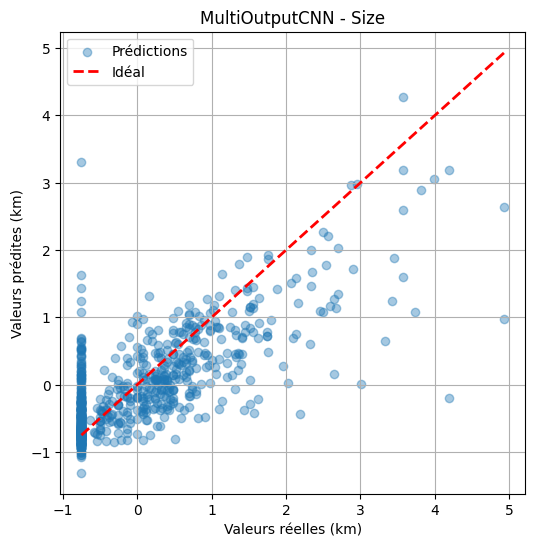


=== ResNet+CNN ===
Wind     -> MSE: 0.11 | RMSE: 0.34 | R²: 0.898


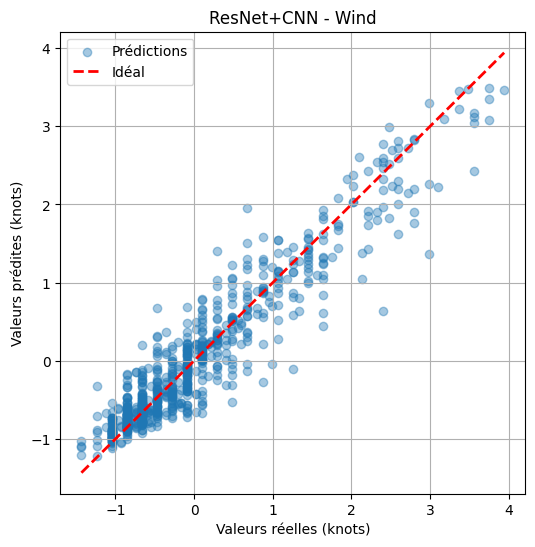

Pressure -> MSE: 0.09 | RMSE: 0.31 | R²: 0.915


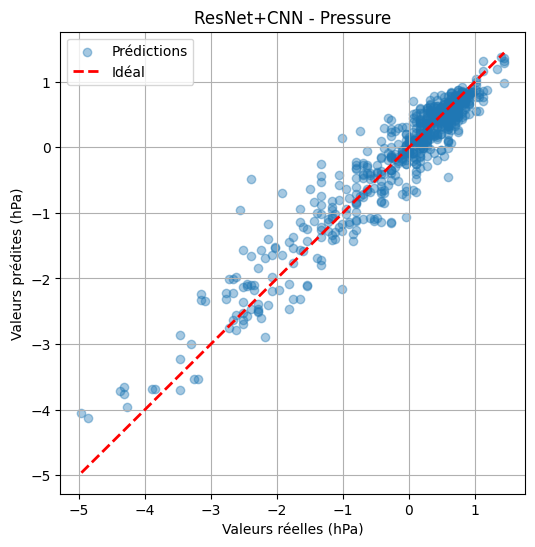

Size     -> MSE: 0.28 | RMSE: 0.53 | R²: 0.725


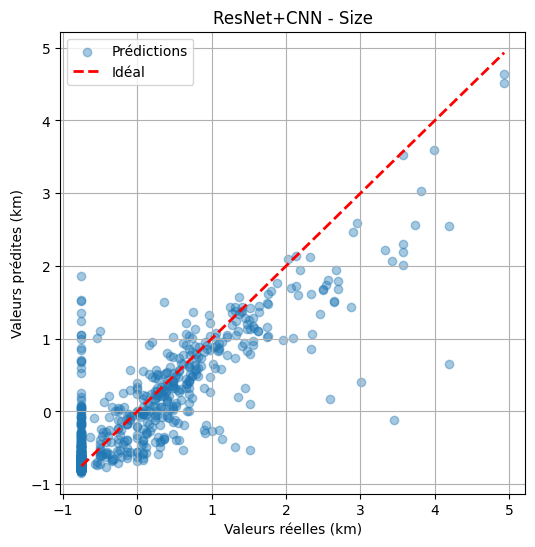


=== ViT+CNN ===
Wind     -> MSE: 0.19 | RMSE: 0.44 | R²: 0.826


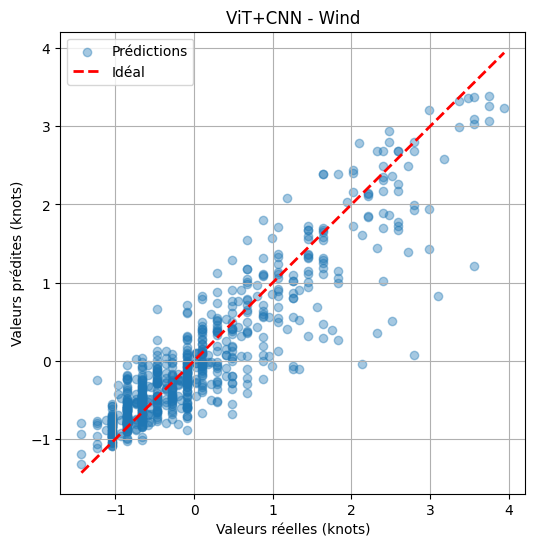

Pressure -> MSE: 0.17 | RMSE: 0.42 | R²: 0.844


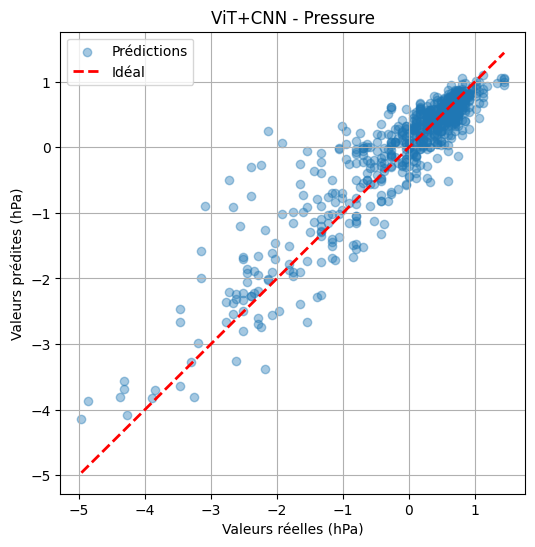

Size     -> MSE: 0.34 | RMSE: 0.58 | R²: 0.669


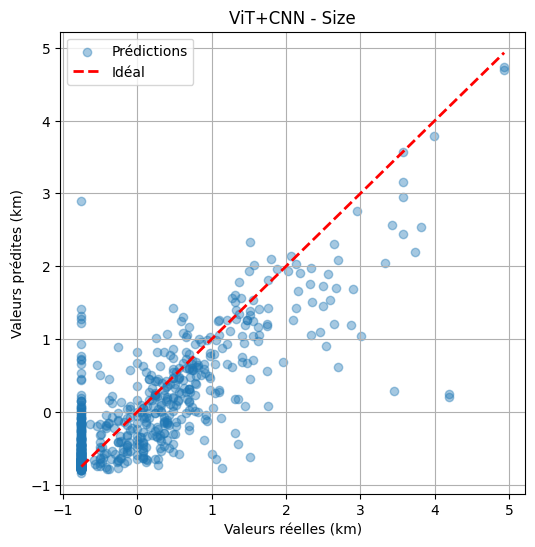

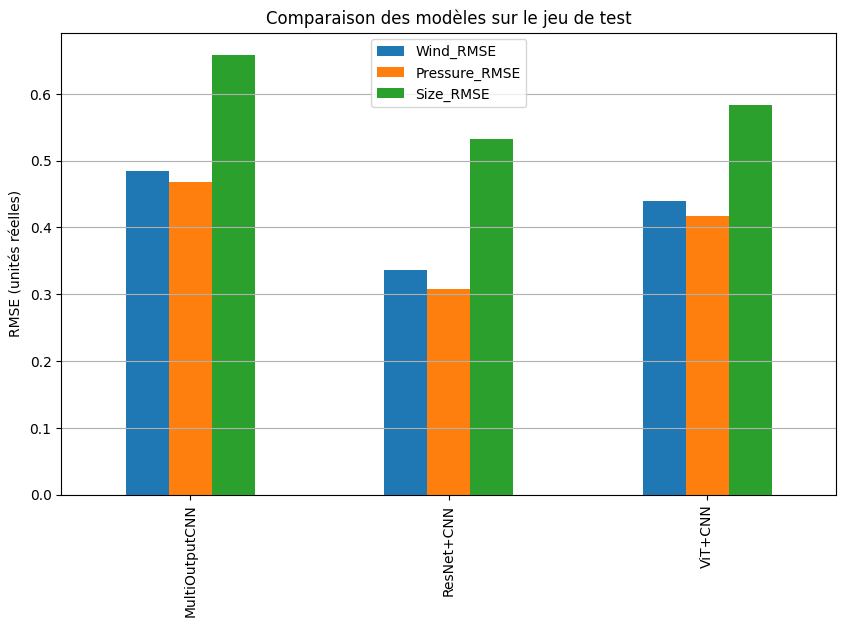

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# --- Fonction utilitaire pour calculer métriques ---
def evaluate_model(model, dataloader, device="cuda"):
    model.eval()
    y_true_w, y_pred_w = [], []
    y_true_p, y_pred_p = [], []
    y_true_s, y_pred_s = [], []

    with torch.no_grad():
        for images, wind, pressure, size in dataloader:
            images = images.to(device)
            wind = wind.cpu().numpy()
            pressure = pressure.cpu().numpy()
            size = size.cpu().numpy()

            out_w, out_p, out_s = model(images)
            out_w = out_w.cpu().numpy()
            out_p = out_p.cpu().numpy()
            out_s = out_s.cpu().numpy()

            y_true_w.extend(wind)
            y_pred_w.extend(out_w)
            y_true_p.extend(pressure)
            y_pred_p.extend(out_p)
            y_true_s.extend(size)
            y_pred_s.extend(out_s)

    # numpy arrays
    y_true_w, y_pred_w = np.array(y_true_w), np.array(y_pred_w)
    y_true_p, y_pred_p = np.array(y_true_p), np.array(y_pred_p)
    y_true_s, y_pred_s = np.array(y_true_s), np.array(y_pred_s)

    # métriques
    metrics = {}
    for name, y_true, y_pred in [
        ("Wind", y_true_w, y_pred_w),
        ("Pressure", y_true_p, y_pred_p),
        ("Size", y_true_s, y_pred_s)
    ]:
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        metrics[name] = {"MSE": mse, "RMSE": rmse, "R2": r2,
                         "y_true": y_true, "y_pred": y_pred}
    return metrics

# --- Scatterplot ---
def plot_results(y_true, y_pred, var_name, unit, model_name):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, alpha=0.4, label="Prédictions")
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()],
             'r--', lw=2, label="Idéal")
    plt.xlabel(f"Valeurs réelles ({unit})")
    plt.ylabel(f"Valeurs prédites ({unit})")
    plt.title(f"{model_name} - {var_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Dictionnaire des modèles ---
models = {
    "MultiOutputCNN": best_model,
    "ResNet+CNN": best_resnet_cnn,
    "ViT+CNN": best_vit
}

results_all = {}

# ⚡ Evaluation
for name, model in models.items():
    print(f"\n=== {name} ===")
    metrics = evaluate_model(model, test_loader, device=device)
    results_all[name] = {k: v for k,v in [(f"{m}_RMSE", metrics[m]["RMSE"]) for m in metrics]}

    # affichage textuel
    for var, vals in metrics.items():
        print(f"{var:8} -> MSE: {vals['MSE']:.2f} | RMSE: {vals['RMSE']:.2f} | R²: {vals['R2']:.3f}")
        # scatterplot
        unit = "knots" if var=="Wind" else ("hPa" if var=="Pressure" else "km")
        plot_results(vals["y_true"], vals["y_pred"], var, unit, model_name=name)

# --- Comparaison en barplot ---
df_results = pd.DataFrame(results_all).T
df_results.plot(kind="bar", figsize=(10,6))
plt.ylabel("RMSE (unités réelles)")
plt.title("Comparaison des modèles sur le jeu de test")
plt.grid(axis="y")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

def denormalize(y, mean, std):
    """Reverse standardization to physical units."""
    return y * std + mean

def compare_models(models_dict, test_loader, label_stats, device="cuda"):
    """
    Compare multiple models on the same test sample.

    Args:
        models_dict: dict { "ModelName": model }
        test_loader: DataLoader
        label_stats: dict with mean/std for each target
        device: torch device

    Displays:
        - One test sample (composite of 3 channels + PMW channel)
        - True values vs predictions for each model
    """
    # --- Get one batch ---
    images, wind, pressure, size = next(iter(test_loader))
    images, wind, pressure, size = (
        images.to(device),
        wind.to(device),
        pressure.to(device),
        size.to(device),
    )

    # --- Take only the first sample (change index if needed) ---
    i = 21
    composite = images[i, :3].cpu().permute(1, 2, 0).numpy()  # (IR, WV, VIS)
    pmw       = images[i, 3].cpu().numpy()                    # Passive Microwave

    # --- Denormalize ground truth ---
    mean_w, std_w = label_stats["wind"]
    mean_p, std_p = label_stats["pressure"]
    mean_s, std_s = label_stats["size"]

    wind_true     = denormalize(wind[i].item(), mean_w, std_w)
    pressure_true = denormalize(pressure[i].item(), mean_p, std_p)
    size_true     = denormalize(size[i].item(), mean_s, std_s)

    # --- Plot composite + PMW channel ---
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(composite)
    axs[0].set_title("Composite (IR, WV, VIS)")
    axs[0].axis("off")

    axs[1].imshow(pmw, cmap="inferno")
    axs[1].set_title("Passive Microwave (PMW)")
    axs[1].axis("off")

    plt.suptitle("Satellite Sample", fontsize=14)
    plt.show()

    # --- Collect predictions ---
    print(f" Ground Truth:\n"
          f"    Wind     = {wind_true:.2f} knots\n"
          f"    Pressure = {pressure_true:.2f} hPa\n"
          f"    Size     = {size_true:.2f} km\n")

    for name, model in models_dict.items():
        model.eval()
        with torch.no_grad():
            out_wind, out_pressure, out_size = model(images)

        wind_pred     = denormalize(out_wind[i].item(), mean_w, std_w)
        pressure_pred = denormalize(out_pressure[i].item(), mean_p, std_p)
        size_pred     = denormalize(out_size[i].item(), mean_s, std_s)

        print(f" {name} Prediction:")
        print(f"    Wind     = {wind_pred:.2f} knots")
        print(f"    Pressure = {pressure_pred:.2f} hPa")
        print(f"    Size     = {size_pred:.2f} km\n")


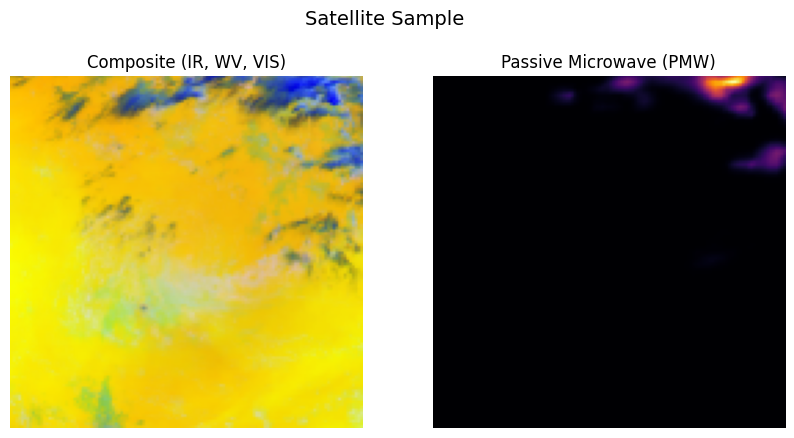

 Ground Truth:
    Wind     = 33.00 knots
    Pressure = 998.00 hPa
    Size     = 37.50 km

 MultiOutputCNN Prediction:
    Wind     = 22.76 knots
    Pressure = 1008.32 hPa
    Size     = 1.69 km

 ResNet+CNN Prediction:
    Wind     = 25.36 knots
    Pressure = 1005.97 hPa
    Size     = 6.46 km

 ViT+CNN Prediction:
    Wind     = 27.07 knots
    Pressure = 1005.89 hPa
    Size     = 4.65 km



In [ ]:
models_dict = {
    "MultiOutputCNN": best_model,
    "ResNet+CNN": best_resnet_cnn,
    "ViT+CNN": best_vit
}

compare_models(models_dict, test_loader, label_stats, device=device)


#  Conclusion & Interpretation of the Models  

## 1. MultiOutputCNN (baseline)  
- This simple CNN captures some relevant spatial features but remains limited.  
- Results show decent performance on **wind** and **pressure**, but **size prediction** remains unstable (low R²).  
- This model demonstrates the **importance of a stronger feature extractor** for complex satellite patterns.  

---

## 2. ResNet+CNN (best performer)  
- ResNet backbone (trained on ImageNet) extracts **hierarchical spatial patterns** that are highly relevant to satellite data.  
- The CNN branch for the **Passive Microwave (PMW) channel** (4th channel) allows the model to integrate **spectral information not available in the pseudo-RGB channels (IR, VIS, WV)**.  
- **Results:**  
  - Strong improvements on **wind** and **pressure** prediction (R² ≈ 0.90+).  
  - Better handling of **storm size**, although still more challenging.  
- **Why ResNet wins:**  
  - Transfer learning: pretrained filters already capture edges, textures, and patterns that generalize well.  
  - CNN for PMW fusion is lightweight but effective.  
  - Convergence is fast and stable.  

---

## 3. ViT+CNN (Vision Transformer)  
- ViTs model **global relationships** in the image thanks to the self-attention mechanism.  
- **Advantages:** theoretically more powerful to capture **long-range spatial dependencies**, crucial in large storm systems.  
- **Limitations in this project:**  
  - Transformers require **large datasets** to unleash their full potential.  
  - Even with unfreezing the last 3 layers, performance remains behind ResNet.  
- **Interpretation:** the ViT shows **potential** but is not yet fully exploited here.  

---

##  Key Takeaways  
1. **ResNet outperforms** in this context because satellite storm detection benefits from **local-to-global spatial hierarchies** that CNNs are naturally good at.  
2. **ViT is promising**, especially if:  
   - More training data is available.  
   - We leverage **pretraining on satellite imagery** (e.g., ClimateNet, SatMAE, etc.), not just ImageNet.  
   - We combine CNN + ViT hybrid architectures (best of both worlds).  
3. **Passive Microwave (PMW) channel fusion** is essential — the experiments show that the **4th channel adds strong predictive power** beyond the pseudo-RGB (IR, VIS, WV).  
  
